# Lensing Model Inference

Set up a full-field lensing forward model, generate synthetic data, and run a small illustrative inference with `fwd_model_tools`.


In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["JAX_ENABLE_X64"] = "False"
os.environ["JAX_PLATFORM_NAME"] ='cpu'

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import jax_cosmo as jc
import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

from fwd_model_tools.probabilistic_models import Configurations, Planck18, full_field_probmodel
from fwd_model_tools.initial import gaussian_initial_conditions
from fwd_model_tools.utils import compute_box_size_from_redshift
from fwd_model_tools.sampling import plot_posterior
from fwd_model_tools.sampling import batched_sampling, PreconditionnedUniform, load_samples
from fwd_model_tools.fields import AbstractField, SphericalKappaField, SphericalDensity, FieldStatus


/home/wassim/Projects/NBody/jax_cosmo/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR:2025-12-11 14:33:49,960:jax._src.xla_bridge:477: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 475, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__in

## Configuration

In [2]:
if jax.device_count() > 1:
    from jax.sharding import NamedSharding
    from jax.sharding import PartitionSpec as P

    pdims = (2 , 4 , 2)

    mesh = jax.make_mesh(pdims, ("chain" , "x", "y"))
    sharding = NamedSharding(mesh, P("x", "y"))
    print(f"Using sharding with mesh: {pdims}")
else:
    sharding = None
    print("Single device mode - no sharding")


Single device mode - no sharding


Box size: (3884.212449617192, 3884.212449617192, 3884.212449617192) Mpc/h


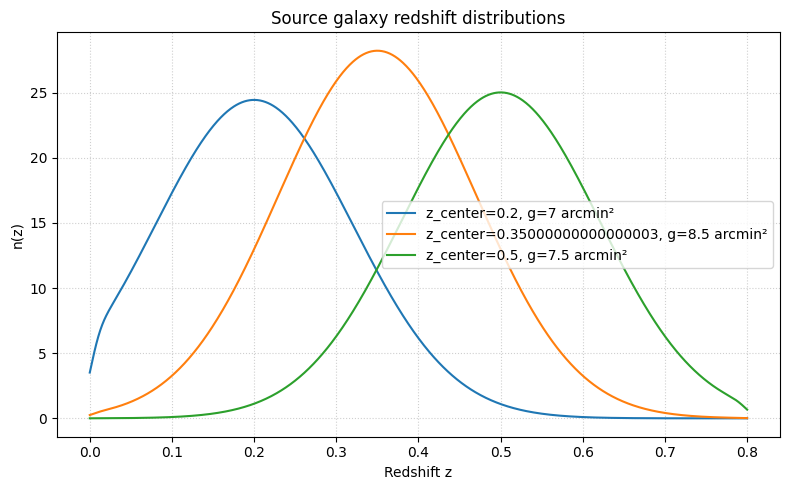

In [3]:
# Geometry and cosmology
mesh_shape = (256 , 256 ,256)  # small for a quick demo
max_redshift = 0.8
observer_position = (0.5, 0.5, 0.5)
fiducial_cosmology = Planck18()

# Compute box size that reaches the target redshift
box_size = compute_box_size_from_redshift(fiducial_cosmology, max_redshift, observer_position).squeeze()
box_size = tuple(map(float, box_size))
print(f"Box size: {box_size} Mpc/h")

# Redshift distribution (three Gaussian bins)
from scipy.stats import norm
z = jnp.linspace(0, max_redshift, 1000)
z_centers = jnp.linspace(0.2, max_redshift - 0.3, 3)
z_centers = jnp.round(z_centers, 3)
nz_shear = [
    jc.redshift.kde_nz(
        z,
        norm.pdf(z, loc=z_center, scale=0.12),
        bw=0.01,
        zmax=max_redshift,
        gals_per_arcmin2=g,
    )
    for z_center, g in zip(z_centers, [7, 8.5, 7.5])
]

fig_nz, ax = plt.subplots(figsize=(8, 5))
for i, nz in enumerate(nz_shear):
    ax.plot(z, nz(z) * nz.gals_per_arcmin2, label=f"z_center={z_centers[i]}, g={nz.gals_per_arcmin2} arcmin²")
ax.set_xlabel("Redshift z")
ax.set_ylabel("n(z)")
ax.set_title("Source galaxy redshift distributions")
ax.legend()
ax.grid(True, which="both", ls=":", alpha=0.6)
fig_nz.tight_layout()
plt.show()


In [4]:
# Configurations
config = Configurations(
    density_plane_smoothing=0.5,
    nz_shear=nz_shear,
    fiducial_cosmology=Planck18,
    sigma_e=0.3,
    priors={
        "Omega_c": PreconditionnedUniform(0.2, 0.4),
        "sigma8": PreconditionnedUniform(0.6, 1.0),
    },
    t0=0.1,
    dt0=0.05,
    t1=1.0,
    min_redshift=0.01,
    max_redshift=max_redshift,
    geometry="spherical",
    log_lightcone=True,
    log_ic=True,
    number_of_shells=16,
    lensing=True,
    lpt_order=1,
)
config.nside = 256
config.observer_position = observer_position
config.box_size = box_size


## Model Initialization

In [5]:
meta_data = AbstractField(
    array=None,
    mesh_size=mesh_shape,
    box_size=box_size,
    observer_position=observer_position,
    nside=config.nside,
)

model = full_field_probmodel(meta_data, config)


## Generate Synthetic Observations

In [ ]:
initial_field = gaussian_initial_conditions(
    jax.random.PRNGKey(0),
    mesh_size=mesh_shape,
    box_size=box_size,
    cosmo=fiducial_cosmology,
    observer_position=observer_position,
    nside=config.nside,
)

true_params = {"Omega_c": 0.26, "sigma8": 0.81, "initial_conditions": initial_field.array}

datagen_model = condition(model, true_params)
traced = trace(seed(datagen_model, jax.random.PRNGKey(42))).get_trace()

obs_kappa = {f"kappa_{i}": traced[f"kappa_{i}"]["value"] for i in range(len(nz_shear))}
obs_kappa_field = SphericalKappaField.FromDensityMetadata(
    array=jnp.stack([obs_kappa[f"kappa_{i}"] for i in range(len(nz_shear))]),
    field=initial_field,
)

lightcone_array = traced["lightcone"]["value"]
lightcone_z = traced["lightcone_z"]["value"]
lightcone_field = SphericalDensity.FromDensityMetadata(
    array=lightcone_array[-4:],
    field=initial_field,
    z_sources=lightcone_z[-4:],
    status=FieldStatus.LIGHTCONE,
)

print("Observations generated.")
print("Kappa shape:", obs_kappa_field.shape)
print("Lightcone shape:", lightcone_array.shape)
print("Lightcone redshifts:", lightcone_z)


Number of kappa fields: (3, 786432) number of nz_shear: 3
Observations generated.
Kappa shape: (3, 786432)
Lightcone shape: (16, 786432)
Lightcone redshifts: 

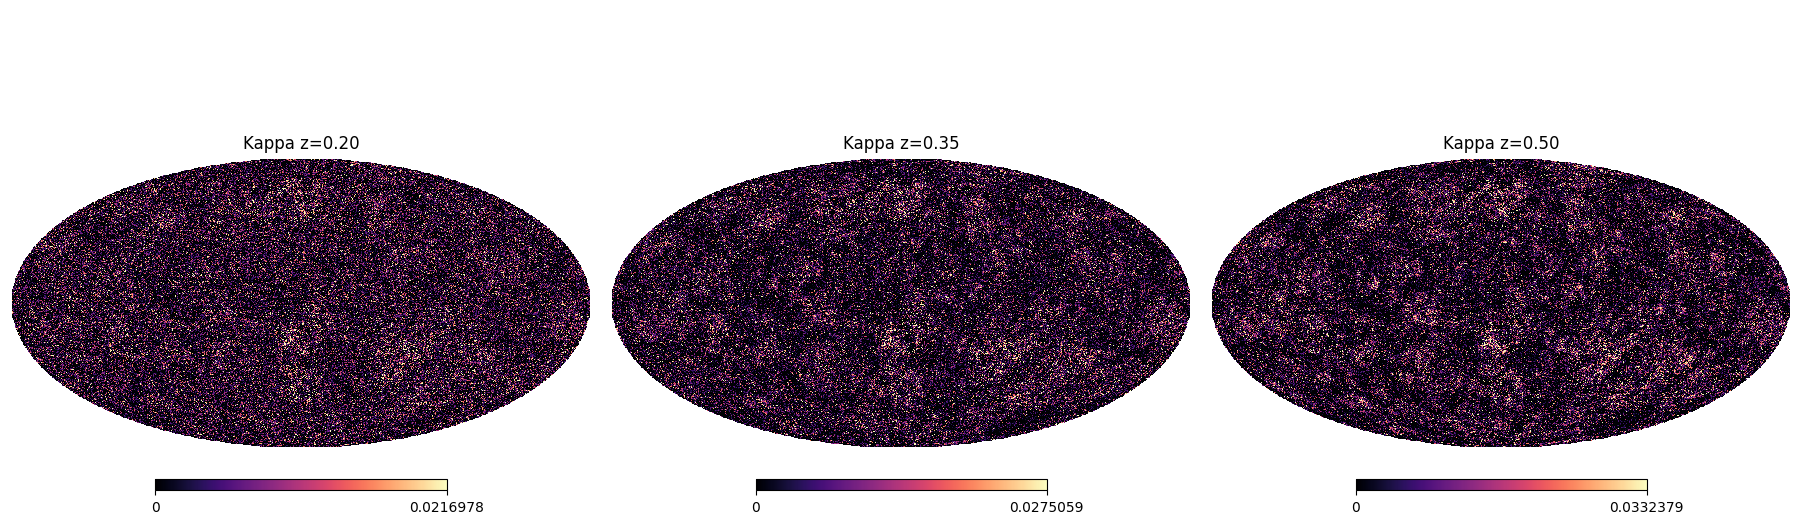

In [ ]:
# Plot observed kappa maps
obs_kappa_field.show(titles=[f"Kappa z={z_centers[i]:.2f}" for i in range(len(nz_shear))])


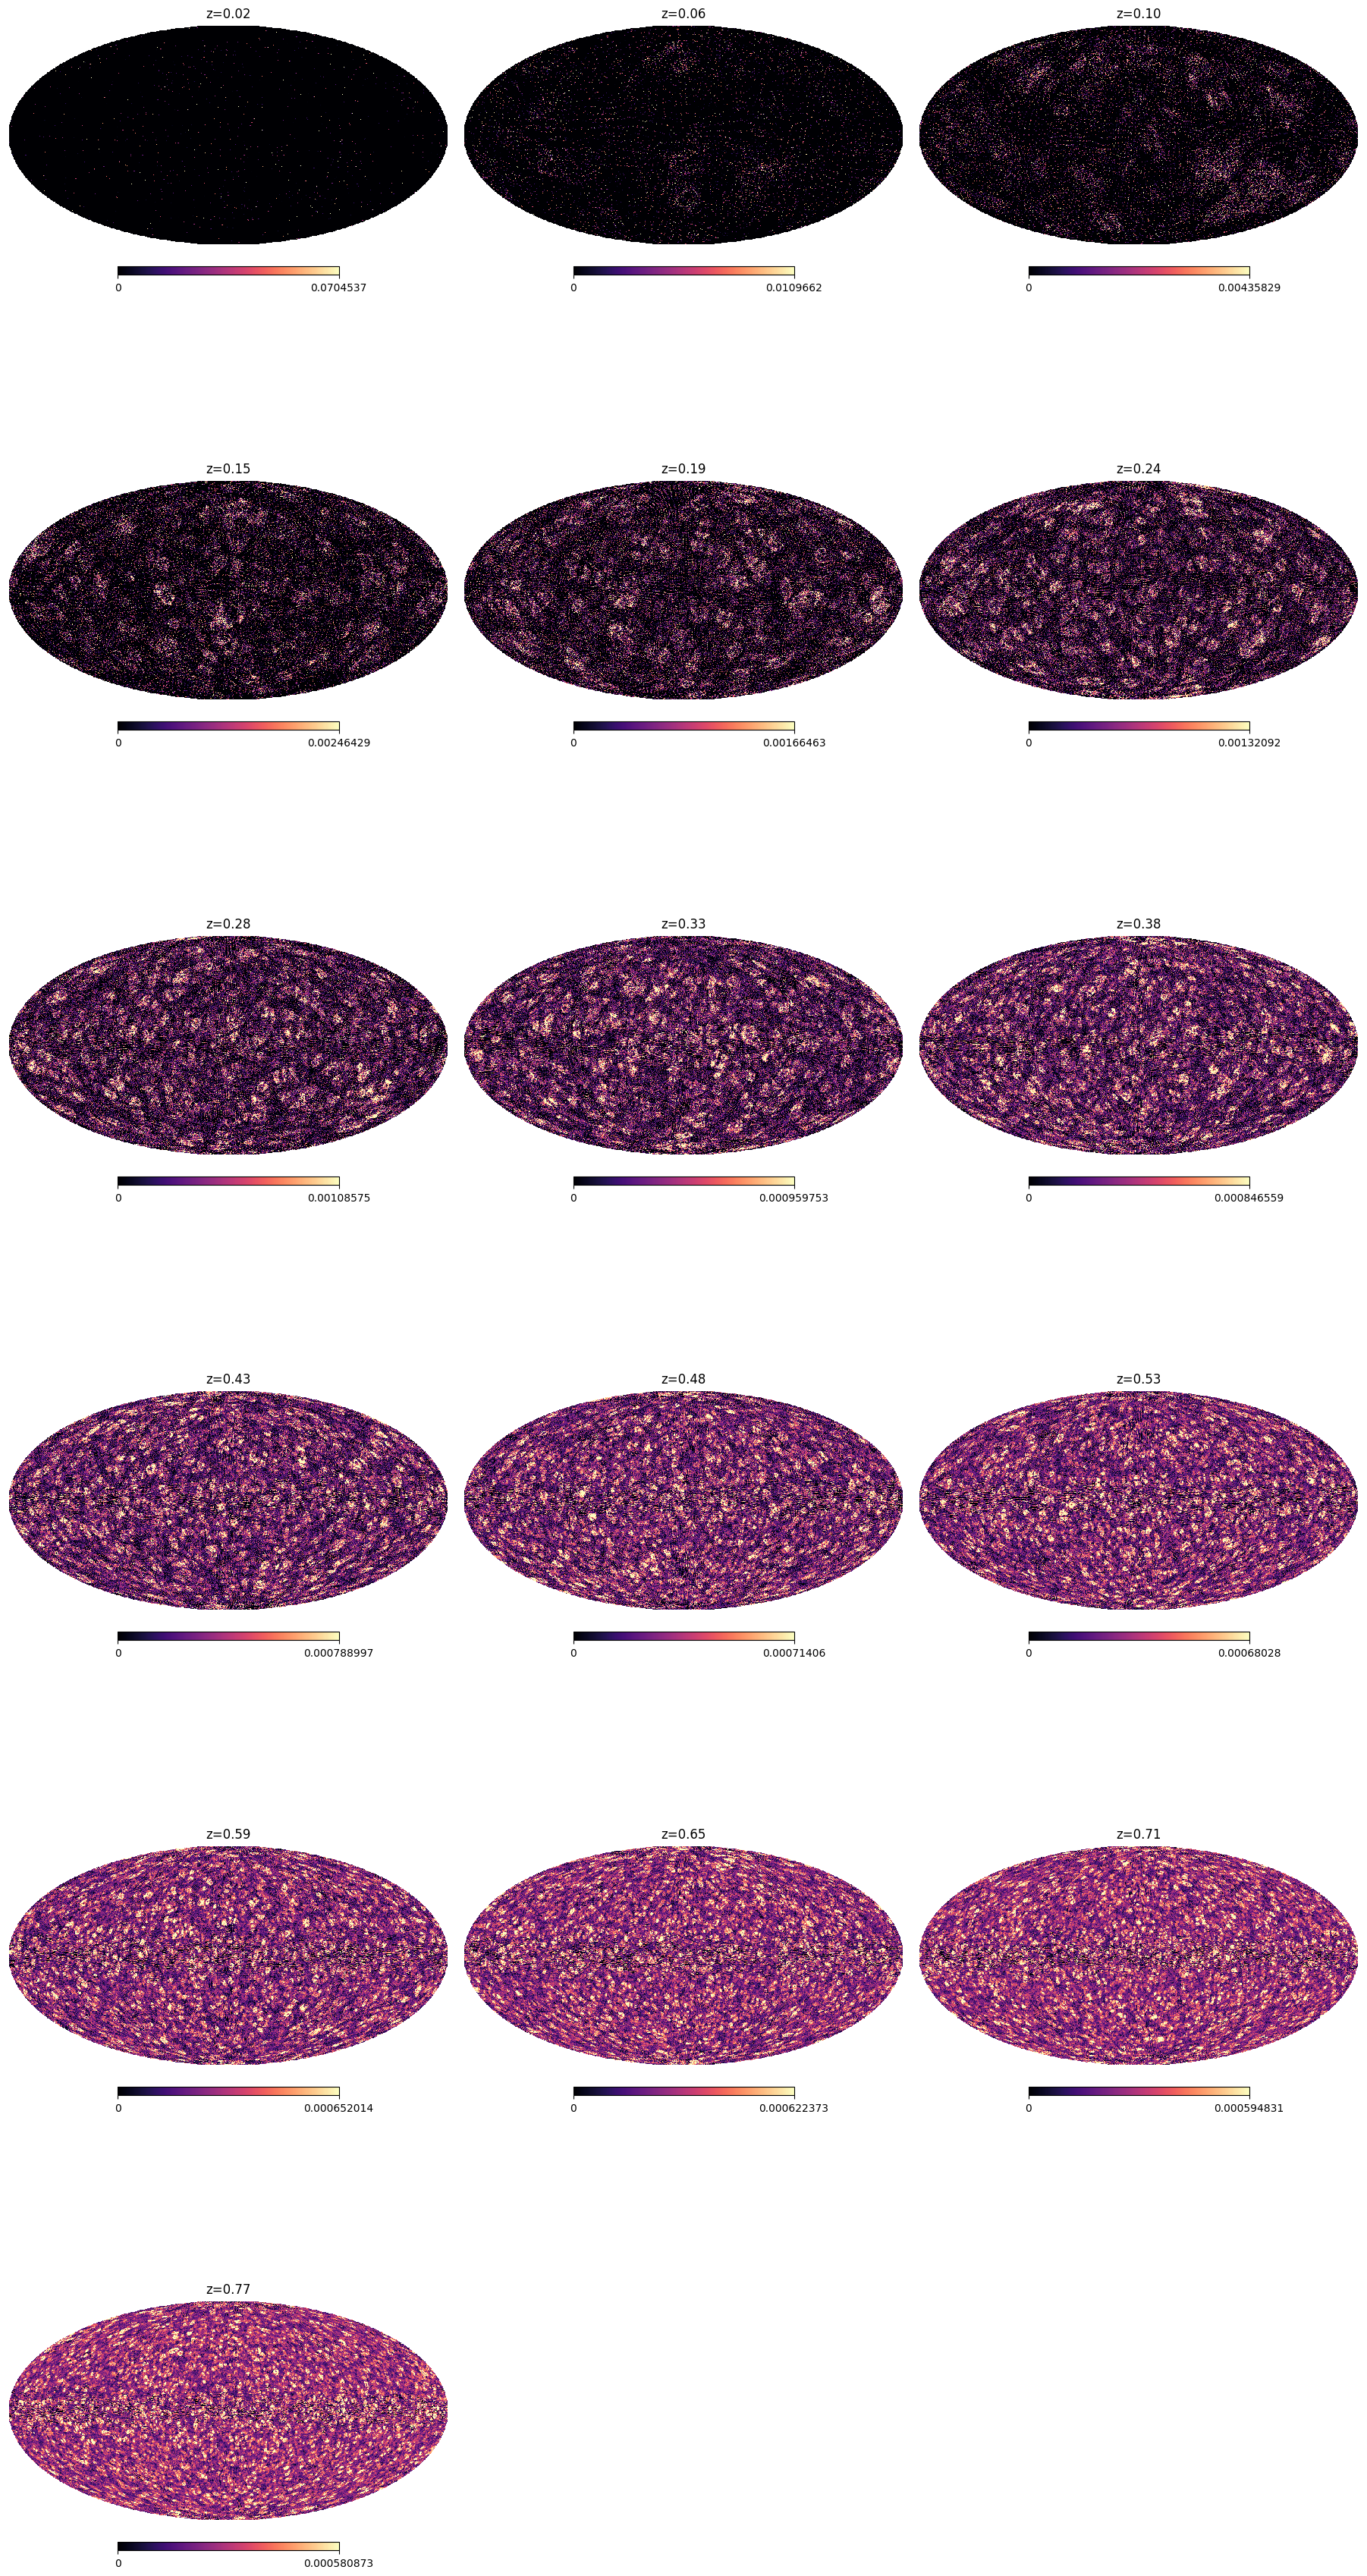

In [ ]:
# Plot lightcone density planes
slices = slice(0 , 2)
lightcone_field.apply_fn(jnp.log1p).show(titles=[f"z={z:.2f}" for z in lightcone_z])


## Inference

In [ ]:
observed_model = condition(model, obs_kappa)

batched_sampling(
    observed_model,
    path="output/lensing_inference",
    rng_key=jax.random.PRNGKey(0),
    num_warmup=16,
    num_samples=16,
    batch_count=16,
    sampler="NUTS",
    backend="blackjax",
    progress_bar=True,
    chain_spec=P('chain')
)


## Analysis

In [ ]:
true_params = {"Omega_c": 0.26, "sigma8": 0.81}
samples = load_samples("output/lensing_inference", param_names=["Omega_c", "sigma8"])
print(f"Loaded samples: {list(samples.keys())}")
print(f"Number of samples: {samples['Omega_c'].shape[0]}")

plot_posterior(
    samples,
    outdir="output/lensing_inference",
    params=("Omega_c", "sigma8"),
    true_values=true_params,
    labels={"Omega_c": r"Omega_c", "sigma8": r"sigma8"},
    output_format="png",
)


### Wrap-up

This notebook generates synthetic weak-lensing observations, runs a small batched NUTS inference (16×16×16 samples), and saves posterior plots to `output/lensing_inference`.
